# Custom destinations & Reverse ETL

---

## What you’ll learn

- What reverse ETL means in practice  
- How to build custom destinations with `@dlt.destination`  
- How batching works  
- How to push real data from Rfam database to Notion  

---


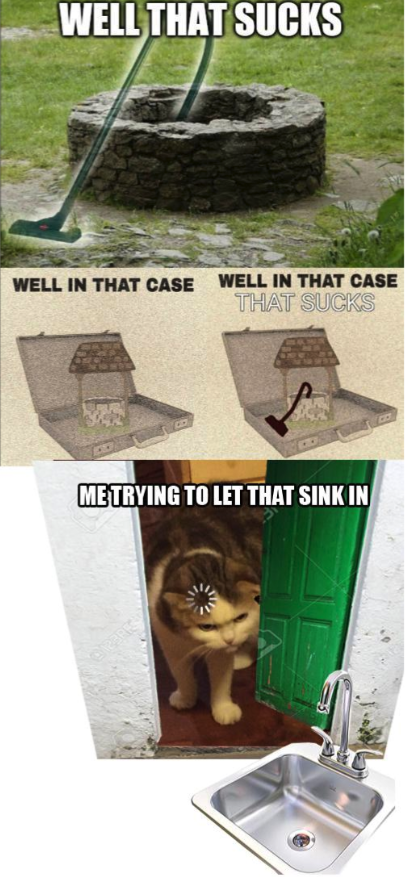


## **1. Concept: What is a custom destination?**

Normally, dlt sends your data to databases like BigQuery or Postgres.

But with `@dlt.destination`, you can **intercept the normalized data** and send it wherever you want:
- APIs (Notion, Slack, Airtable)
- Message queues (Kafka, SQS)
- Logging systems
- Custom data sinks

All you have to do is define a function like:

```python
@dlt.destination
def my_destination(items, table):
    ...
```

And dlt will call this for every batch of data extracted and normalized.



---

## **2. Simple example: print data rows**

### Code example:

In [1]:
%%capture
!pip install dlt[duckdb]

In [2]:
import dlt
from dlt.common.typing import TDataItems
from dlt.common.schema import TTableSchema


@dlt.destination(batch_size=5)
def print_sink(items: TDataItems, table: TTableSchema):
    print(f"\nTable: {table['name']}")
    for item in items:
        print(item)


@dlt.resource
def simple_data():
    yield [{"id": i, "value": f"row-{i}"} for i in range(12)]


pipeline = dlt.pipeline("print_example", destination=print_sink)
pipeline.run(simple_data())
print(pipeline.last_trace)


Table: simple_data
{'id': 0, 'value': 'row-0'}
{'id': 1, 'value': 'row-1'}
{'id': 2, 'value': 'row-2'}
{'id': 3, 'value': 'row-3'}
{'id': 4, 'value': 'row-4'}

Table: simple_data
{'id': 5, 'value': 'row-5'}
{'id': 6, 'value': 'row-6'}
{'id': 7, 'value': 'row-7'}
{'id': 8, 'value': 'row-8'}
{'id': 9, 'value': 'row-9'}

Table: simple_data
{'id': 10, 'value': 'row-10'}
{'id': 11, 'value': 'row-11'}
Run started at 2025-05-10 09:37:05.292080+00:00 and COMPLETED in 0.19 seconds with 4 steps.
Step extract COMPLETED in 0.08 seconds.

Load package 1746869825.3247588 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.05 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- simple_data: 12 row(s)

Load package 1746869825.3247588 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.04 seconds.
Pipeline print_example load step completed in 0.02 seconds
1 lo

**What’s happening?**

- `simple_data()` yields 12 small records.
- The data goes through **normalization** (converted to rows + types).
- `@dlt.destination(batch_size=5)` groups these rows into batches of 5.
- For each batch, `print_sink()` is called.
- The `table` parameter tells you which table the batch belongs to.


**Why this is important?**

- This is the **simplest possible custom destination.**
- You’re in control: log, debug, or route data per table.
- It introduces how dlt structures the data and calls your function.


## Question 1:

In the following example, how many times will the function be called?

In [3]:
@dlt.destination(batch_size=2)
def print_sink(items, table):
    print(items)

@dlt.resource
def simple_data():
    yield [{"id": i} for i in range(6)]



## **3. How batching works**

By default `batch_size` is 10.


Let’s tweak just one thing:

In [4]:
@dlt.destination(batch_size=1)
def print_each_row(items, table):
    print(f"Got one row from table {table['name']}:")
    print(items)



pipeline = dlt.pipeline("print_example", destination=print_each_row)
pipeline.run(simple_data())
print(pipeline.last_trace)

2025-05-10 09:39:31,052|[WARNING]|241|134160045838336|dlt|pipeline.py|_state_to_props:1615|The destination __main__.PrintSinkDestination:print_sink in state differs from destination __main__.PrintEachRowDestination:print_each_row in pipeline and will be ignored


Got one row from table simple_data:
[{'id': 0}]
Got one row from table simple_data:
[{'id': 1}]
Got one row from table simple_data:
[{'id': 2}]
Got one row from table simple_data:
[{'id': 3}]
Got one row from table simple_data:
[{'id': 4}]
Got one row from table simple_data:
[{'id': 5}]
Run started at 2025-05-10 09:39:31.059970+00:00 and COMPLETED in 0.31 seconds with 4 steps.
Step extract COMPLETED in 0.21 seconds.

Load package 1746869971.2348042 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.04 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- simple_data: 6 row(s)

Load package 1746869971.2348042 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.03 seconds.
Pipeline print_example load step completed in 0.01 seconds
1 load package(s) were loaded to destination print_each_row and into dataset None
The print_each_row destination used

Now, dlt calls your function **once per row** instead of per 5 rows.

Useful if:
- Your API doesn’t support bulk inserts.
- You want fine-grained control or retries.

## **4. Real-world project: Rfam database → Notion**

Let’s build a real pipeline that fetches data from database and **sends it to Notion**.

### Why Notion?

- Notion is a great tool for product/dev teams.
- But dlt doesn’t support Notion as a *destination*.
- So, we’ll build that ourselves.




### 4.1. Step 1: Create a database in Notion

1. Create empty database. [Notion documentation.](https://super.so/blog/6-steps-to-creating-databases-in-notion)
2. [Create integration](https://www.notion.so/profile/integrations) in your Notion Workspace.
3. Connect your database to the integration.
4. Create 3 columns: Accession (title), ID (text), Description (text)

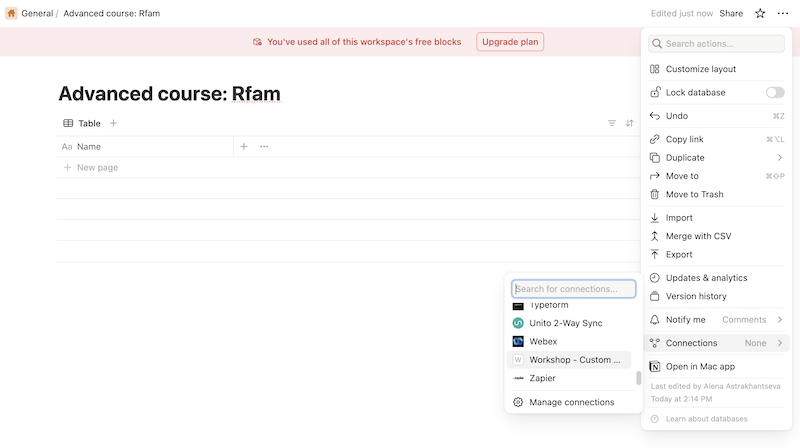

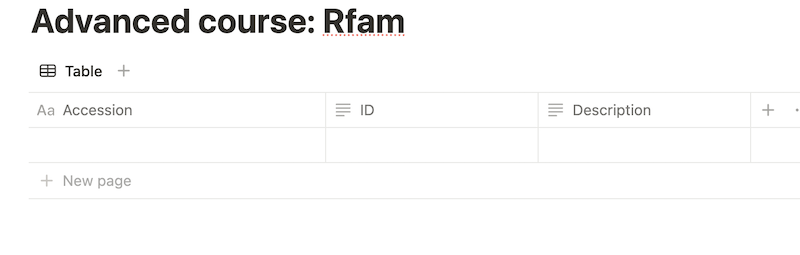

### 4.2. Step 2: Install and configure

In [5]:
%%capture
!pip install dlt pymysql notion-client



2. Set your credentials either in:
  - `~/.dlt/secrets.toml`  
  - or environment variables
  - or (**in our case**) in Colab Secrets

  ```toml
  [destination.notion]
  notion_auth = "<your_integration_token>"
  notion_page_id = "<your_database_id>"
  ```



- Save your [Notion authentication token](https://developers.notion.com/docs/authorization#internal-integration-auth-flow-set-up) and the [ID of the page](https://developers.notion.com/docs/working-with-page-content#creating-a-page-with-content) where you want to create a database in your Colab secrets:

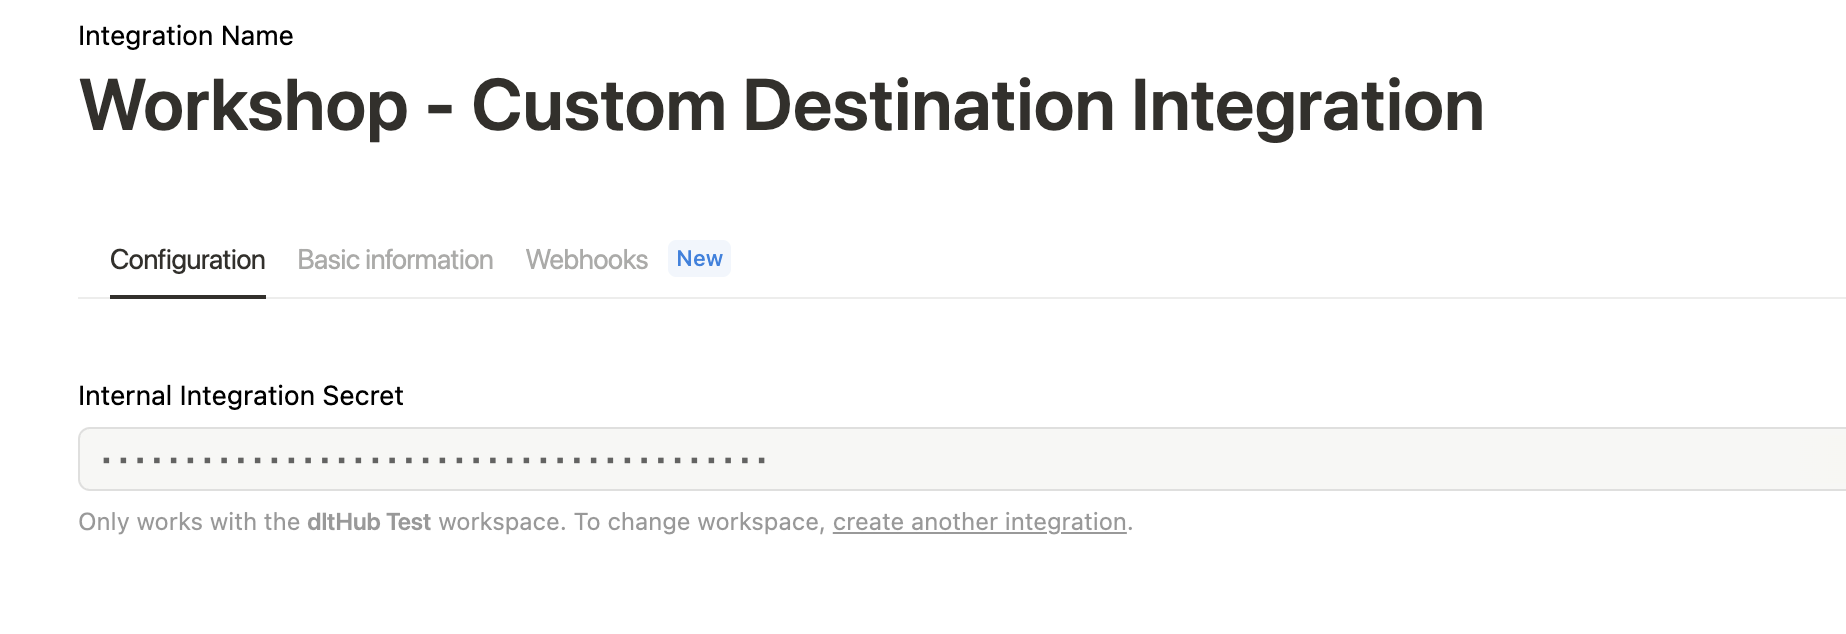

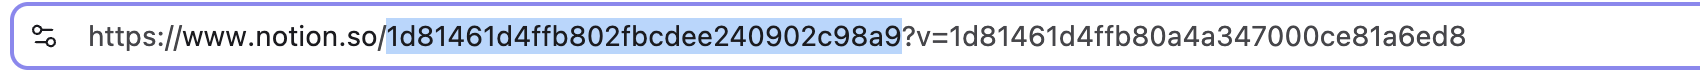

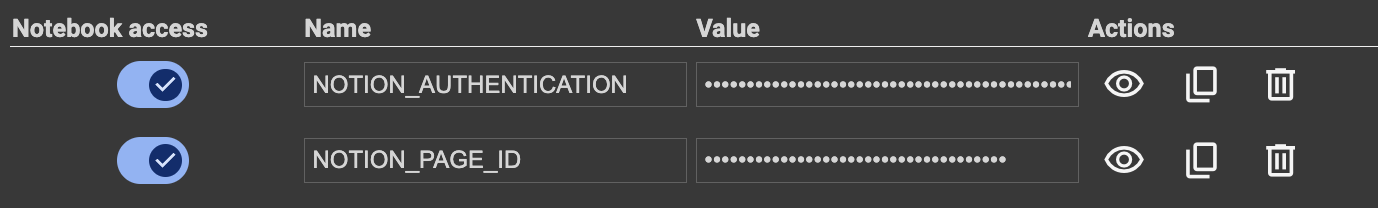

> Make sure to [connect the page](https://www.notion.so/help/add-and-manage-connections-with-the-api#add-connections-to-pages) to the integration associated with the token!

You can also check if your integration works via `curl`:
1. Modify Bearer token
2. Modify "query" if you database have another name

In [ ]:
! curl -X POST 'https://api.notion.com/v1/search' -H 'Authorization: Bearer '"ntn_q5_your_token_o5xQLn1sewnep6"'' -H 'Content-Type: application/json' -H 'Notion-Version: 2022-06-28' --data '{"query": "Advanced", "filter": {"value": "database", "property": "object"}, "sort": {"direction":"ascending", "timestamp":"last_edited_time"}}'

### 4.3. Step 3: Get data from Rfam database

Let's use `query_callback` and limit the number of data rows:

In [ ]:
import os
import dlt
from dlt.sources.sql_database import sql_database

import sqlalchemy as sa
from sqlalchemy import text
from dlt.sources.sql_database import sql_database


def limit_rows(query, table):
    return text(f"SELECT * FROM {table.fullname} LIMIT 20")


source = sql_database(
    "mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam",
    table_names=["family",],
    query_adapter_callback=limit_rows
)


### 4.4. Step 4: Define Notion destination

In [ ]:
import os
from notion_client import Client
from google.colab import userdata

os.environ["DESTINATION__NOTION__NOTION_AUTH"] = userdata.get('NOTION_AUTHENTICATION')
os.environ["DESTINATION__NOTION__NOTION_PAGE_ID"] = userdata.get('NOTION_PAGE_ID')


@dlt.destination(name="notion")
def push_to_notion(items, table, notion_auth=dlt.secrets.value, notion_page_id=dlt.secrets.value):
    client = Client(auth=notion_auth)
    print(len(items))
    for item in items:
        client.pages.create(
            parent={"database_id": notion_page_id},
            properties={
                "Accession": {"title": [{"text": {"content": item["rfam_acc"]}}]},
                "ID": {"rich_text": [{"text": {"content": item["rfam_id"]}}]},
                "Description": {"rich_text": [{"text": {"content": item["description"]}}]}
            }
        )


**What’s happening?**

- dlt will call `push_to_notion()` with one batch of records at a time.
- For each record, we create a page in Notion.
- Credentials and database ID come from `secrets.toml` or env vars.

**Why this is useful?**

- You just turned your pipeline into a full **reverse ETL** job.
- No need for Airbyte or writing custom orchestration scripts.
- It’s reusable and works with dlt’s retry logic, state management, and transformations.


### 4.5. Step 5: Run the pipeline

In [ ]:
pipeline = dlt.pipeline("notion_pipeline", destination=push_to_notion, progress="log")
pipeline.run(source, table_name="rfam_family")
print(pipeline.last_trace)

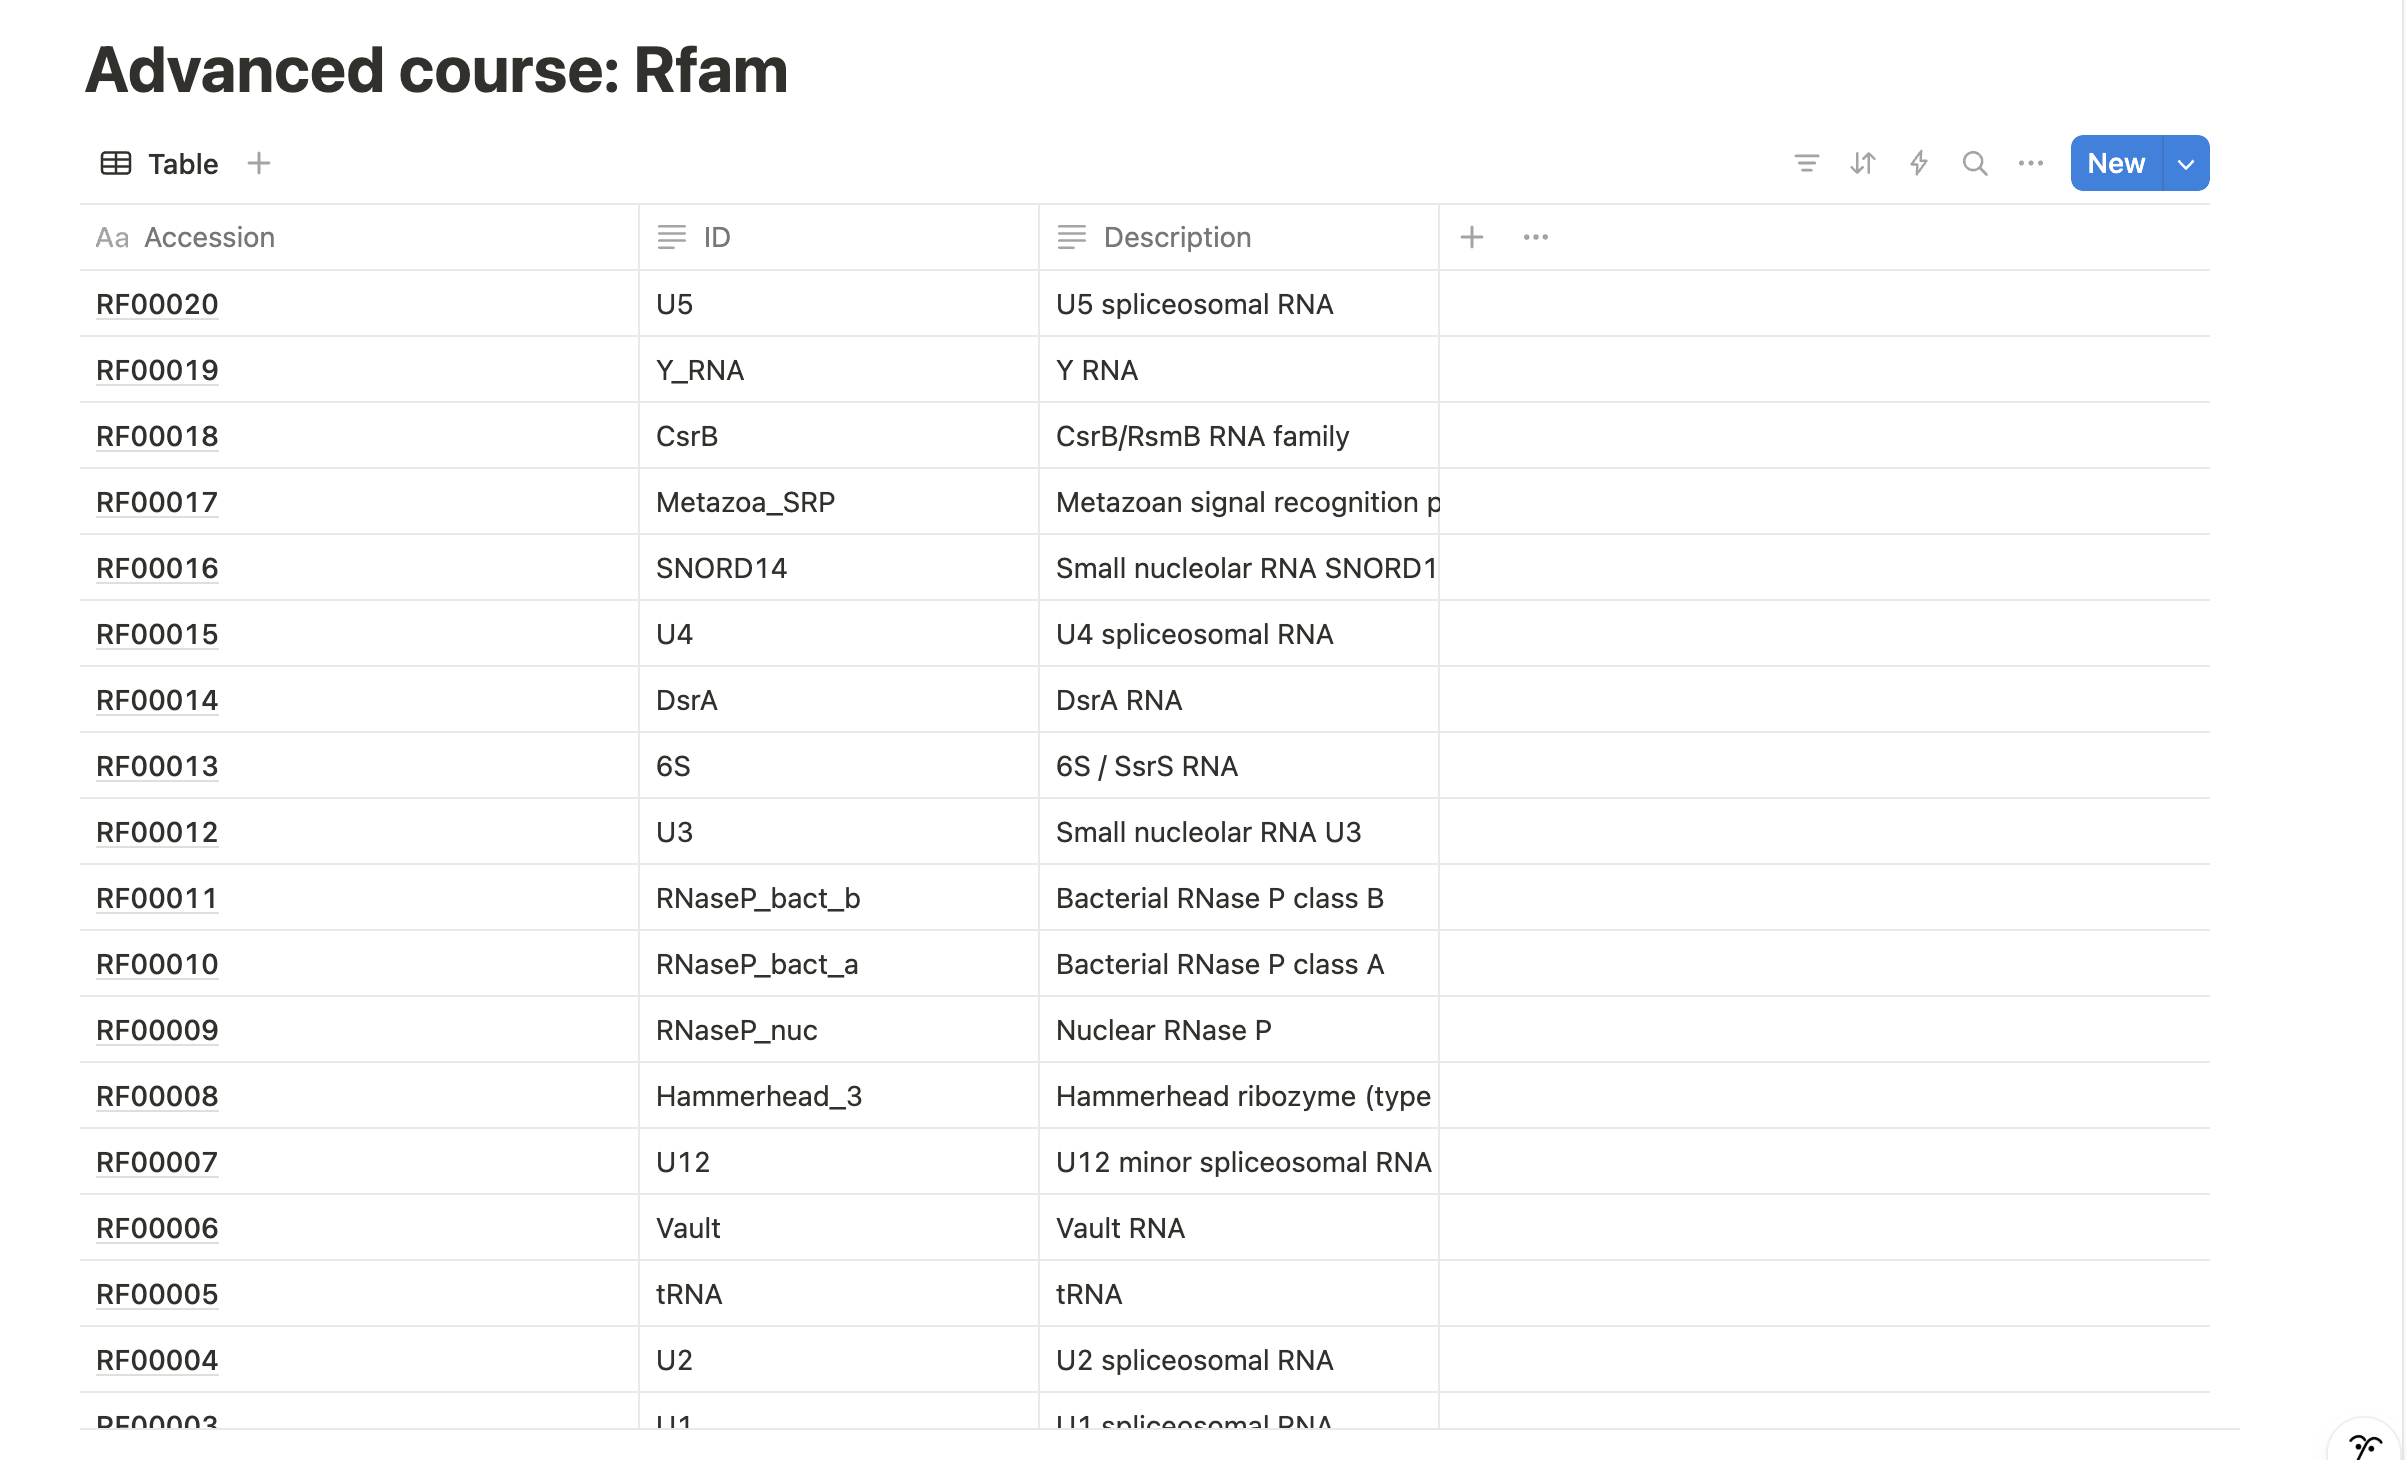



## 5. Reliability and state

### What if Notion fails mid-run?

- dlt **retries batches** up to 5 times.
- You can restart the pipeline and it will continue from the failed batch.
- But you must make your destination **idempotent** (i.e., safe to re-run the same input).


✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1--wNVd26TqNolnnECnUYZqeE2CXOeVZE#forceEdit=true&sandboxMode=true)!